# Timeseries of cross-shore changes from intersection JARKUS with plane at sea level height

**Datasets this notebook expects to find** under the below given datapaths:
- `transect.nc` in folder `datapath_jarkus` containing the JARKUS data on transects which can be downloaded from https://opendap.deltares.nl/thredds/fileServer/opendap/rijkswaterstaat/jarkus/profiles/transect.nc.
- `jarkus_transects_EPSG32631_reduced.geojson` (output of jarkus_shoreline.ipynb, but manually removed overlapping transects in the curvatures with QGIS)
- `TG_rijkswaterstaat_1992_01_01-2021_12_31_corrected.csv` (output of `compare_altimetry_vs_TG.ipynb`)
- `psmsl_monthly_RLR_TERS_1992_01_15-2021_12_17_corrected.csv` (output of `compare_altimetry_vs_TG.ipynb`)
- `altimetry_terschelling_extraced.csv` (output of `compare_altimetry_vs_TG.ipynb`)

Files that are **created** in this notebook (in case they don't exist):
- `transect_red_with_derivatives.nc` (= `transect.nc` reduced to Terschelling and to the period 1992-2022, including derivatives (beach slope in every point of the profile))
- `jarkus_transects_EPSG28992.geojson` (exportet transects)
- `cd_jarkus.pkl` (cross-shore distances computed as intersection of JARKUS profiles with different sea levels)
- `mean_beachslope.pkl` (mean beachslope around the shoreline position)
- `lon_mean.pkl` and `lat_mean.pkl` (coordinates to plot a map with circles at the average shoreline position along each transect)

**Required python modules**
- [coastal_data](https://github.com/3enedix/coastal-sea-level/tree/main/coastal_data)

Parts of this code (where indicated) are adapted from the [Jarkus Analysis Toolbox](https://github.com/christavanijzendoorn/JAT) by Christa van IJzendoorn.

In [1]:
# Fill in your datapaths
main_datapath_input = '/home/bene/PhD-docs/80_papers/1_dataset_combination/data/input/'
main_datapath_output = '/home/bene/PhD-docs/80_papers/1_dataset_combination/data/output/'

## Imports

In [2]:
%load_ext autoreload
%autoreload 2

import xarray as xr
import numpy as np
import pickle
import os
import geojson
import latextable

import pandas as pd
import geopandas as gpd

from scipy import stats
import pymannkendall as mk

import matplotlib.pyplot as plt
from matplotlib import colormaps as cm
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

from coastal_data import CD_statistics, CD_helper_functions

import pdb

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/bene/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [3]:
# matplotlib fontsizes
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 25
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)   # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)   # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

In [4]:
# png image resolution
dpi = 300

## Data

In [5]:
# Compute derivatives
if not os.path.isfile(main_datapath_output + 'transect_red_with_derivatives.nc'):
    jarkus_orig = xr.open_dataset(main_datapath_input + 'transect.nc')

    idx_alongshore = np.where(jarkus_orig.areacode == 4)
    starttime = np.datetime64('1992-01-01')
    idx_time = np.where(jarkus_orig.time >= starttime)
    jarkus_orig_red = jarkus_orig.isel(alongshore = idx_alongshore[0], time = idx_time[0])

    jarkus_orig_red['altitude_red'] = xr.where(jarkus_orig_red.nsources <= 1, jarkus_orig_red.altitude, np.nan)\
    .assign_attrs({"description": "Values coming \"from more than one source\" are masked out based on variable nsources."})

    def compute_derivatives(x, y, n, year, long_coord):
        '''
        n - int
            1/2 filterlength
            n = 1: no smoothing
        '''
        df = np.concatenate((np.ones(n),-np.ones(n)))

        dy = np.convolve(y, df, 'valid')
        dx = np.convolve(x, df, 'valid')

        if max(dx > 200):
            print("Missing values over a distance of ", max(dx), " meters in year ", year, " and alongshore coordinate ", long_coord, ".")
        m = dy / dx
        m = np.append(m, m[-1]) # cheat

        return m

    jarkus_orig_red['altitude_red_1st_derivative'] = xr.full_like(jarkus_orig_red.altitude_red, np.nan)
    jarkus_orig_red['altitude_red_2nd_derivative'] = xr.full_like(jarkus_orig_red.altitude_red, np.nan)

    jarkus_orig_red['altitude_1st_derivative'] = xr.full_like(jarkus_orig_red.altitude, np.nan)
    jarkus_orig_red['altitude_2nd_derivative'] = xr.full_like(jarkus_orig_red.altitude, np.nan)

    n = 5 # 1/2 filterlength
    x1 = jarkus_orig_red.altitude_red.cross_shore
    x2 = x1[n-1:-n+1]

    for time_idx, time in enumerate(jarkus_orig_red.time):
        for long_idx, long_coord in enumerate(jarkus_orig_red.alongshore):
            y_red = jarkus_orig_red.altitude_red[time_idx,long_idx,:]
            m1 = compute_derivatives(x1, y_red, n, str(time.values), str(long_coord.values))
            jarkus_orig_red['altitude_red_1st_derivative'][time_idx,long_idx,n-1:-n+1] = m1
            m2 = compute_derivatives(x2, m1, n, str(time), str(long_coord))
            jarkus_orig_red['altitude_red_2nd_derivative'][time_idx,long_idx,(2*n-2):(-2*n+2)] = m2

            y = jarkus_orig_red.altitude[time_idx,long_idx,:]
            m1 = compute_derivatives(x1, y, n, str(time), str(long_coord))
            jarkus_orig_red['altitude_1st_derivative'][time_idx,long_idx,n-1:-n+1] = m1
            m2 = compute_derivatives(x2, m1, n, str(time), str(long_coord))
            jarkus_orig_red['altitude_2nd_derivative'][time_idx,long_idx,(2*n-2):(-2*n+2)] = m2

    jarkus_orig_red.to_netcdf(main_datapath_output + 'transect_red_with_derivatives.nc')
    jarkus = jarkus_orig_red; del jarkus_orig_red
else:
    jarkus = xr.open_dataset(main_datapath_output + 'transect_red_with_derivatives.nc')

In [6]:
# Export JARKUS transects
if not os.path.isfile(main_datapath_output + 'jarkus_transects_EPSG28992.geojson'):
    x_ters = jarkus.x.values
    y_ters = jarkus.y.values
    featureList = []
    for i, id_trans in enumerate(jarkus.id):
        trans_line_temp = geojson.LineString([(x_ters[i,0], y_ters[i,0]), (x_ters[i,-1], y_ters[i,-1])])
        trans_feature_temp = geojson.Feature(geometry = trans_line_temp, properties = {'name': str(int(id_trans.values))})
        featureList.append(trans_feature_temp)

    transects = geojson.FeatureCollection(featureList)
    with open(main_datapath_output + 'jarkus_transects_EPSG28992.geojson', 'w') as f:
        geojson.dump(transects, f)

In [7]:
# De-select transects (same transects as for CASSIE)
fn = 'jarkus_transects_EPSG32631_reduced.geojson'
transects = gpd.read_file(main_datapath_output + fn).set_index('name')
transects_true = [_ for _ in jarkus.id.values if str(_) in transects.index]
idx_true = np.array([np.where(jarkus.id.values == _)[0][0] for _ in transects_true])
jarkus = jarkus.isel(alongshore=idx_true)

# North Sea tide gauge
tg_northsea = pd.read_csv(main_datapath_output + 'TG_rijkswaterstaat_1992_01_01-2021_12_31_corrected.csv', index_col='datetime[utc]', \
                  parse_dates=['datetime[utc]'])

# PSMSL tide gauge
fn = 'psmsl_monthly_RLR_TERS_1992_01_15-2021_12_17_corrected.csv'
tg_psmsl = pd.read_csv(main_datapath_output + fn, index_col='date', parse_dates=['date'])

# Altimetry
fn = 'altimetry_terschelling_extraced.csv'
alt = pd.read_csv(main_datapath_output + fn, index_col='time', parse_dates=['time'])

In [8]:
# water level yearly averages
tg_northsea_yearly = tg_northsea.groupby(pd.Grouper(freq='Y')).mean()
tg_northsea_yearly = tg_northsea_yearly[1:-1] # 1991 contains only December, 2022 contains only January
tg_psmsl_yearly = tg_psmsl.groupby(pd.Grouper(freq='Y')).mean()
alt_yearly = alt['sla_monthly_av[m]'].groupby(pd.Grouper(freq='Y')).mean()*100

In [9]:
# Bring altimetric SLA to TG/JARKUS NAP by computing the bias as the averaged difference between the timeseries
idx_tg_in_alt = tg_psmsl_yearly.index.isin(alt_yearly.index)
tg_in_alt = tg_psmsl_yearly.iloc[idx_tg_in_alt]

bias_yearly = (alt_yearly - tg_in_alt['ssh_ib_vlm']).dropna().mean()
alt_yearly = alt_yearly - bias_yearly

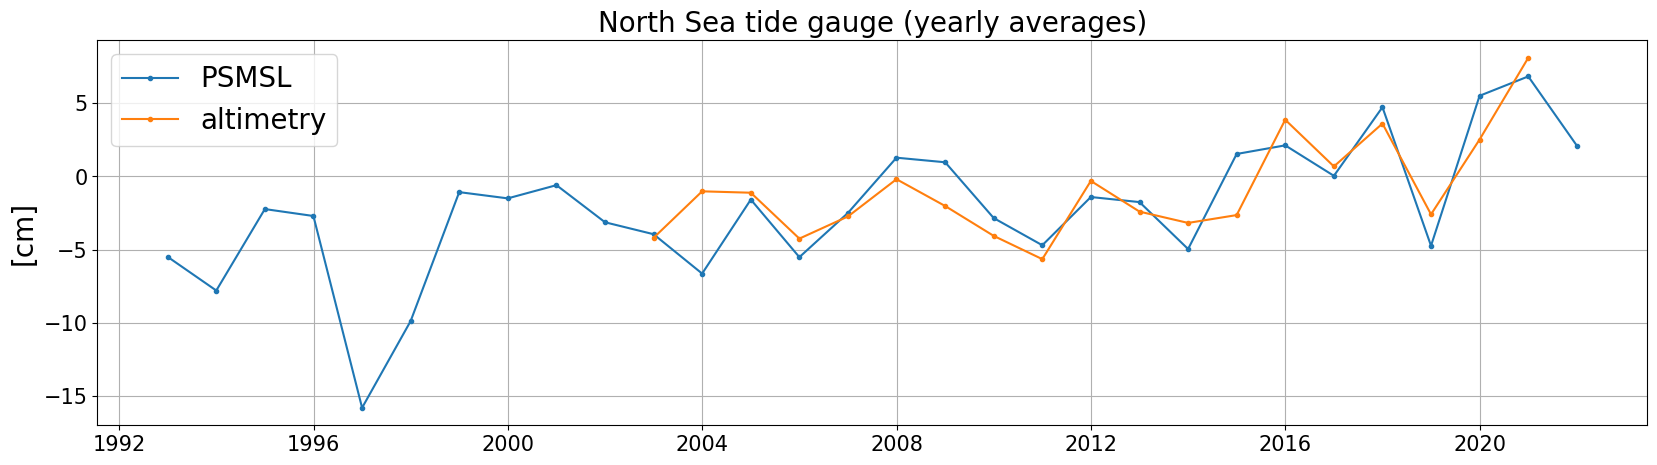

In [10]:
# plot altimetry vs tide gauge
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(tg_psmsl_yearly['ssh_ib_vlm'], '.-', label='PSMSL')
ax.plot(alt_yearly, '.-', label='altimetry')
ax.grid()
ax.legend()
ax.set_title("North Sea tide gauge (yearly averages)")
ax.set_ylabel('[cm]');

2.9585669372149046
1.0040489310422114
4.467490504716976


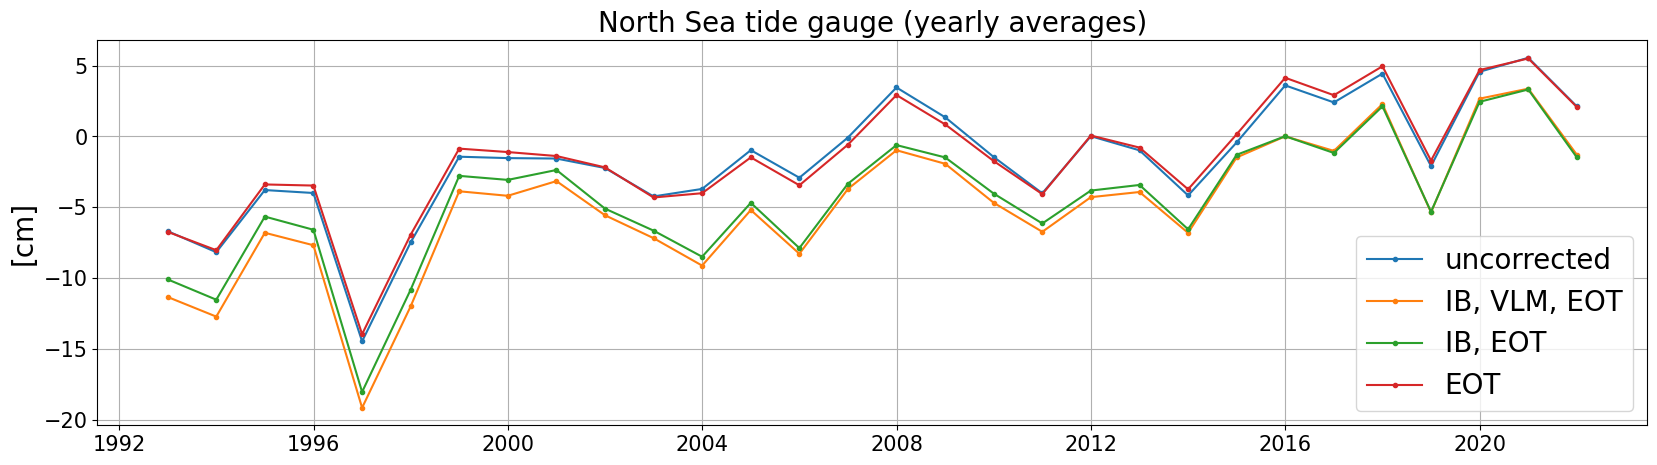

In [11]:
# What are the effects of the tide gauge corrections?
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(tg_northsea_yearly['ssh[cm]'], '.-', label='uncorrected')
ax.plot(tg_northsea_yearly['ssh_ib_vlm_eot[cm]'], '.-', label='IB, VLM, EOT')
ax.plot(tg_northsea_yearly['ssh_ib_vlm_eot[cm]'] + tg_northsea_yearly['corr_vlm[cm]'], '.-', label='IB, EOT')
ax.plot(tg_northsea_yearly['ssh_ib_vlm_eot[cm]'] + tg_northsea_yearly['corr_vlm[cm]'] + tg_northsea_yearly['corr_ib[cm]'], '.-', label='EOT')
ax.grid()
ax.legend()
ax.set_title("North Sea tide gauge (yearly averages)")
ax.set_ylabel('[cm]');

print(tg_psmsl_yearly['corr_ib[cm]'].mean())
print(tg_psmsl_yearly['corr_ib[cm]'].min())
print(tg_psmsl_yearly['corr_ib[cm]'].max())

### Future sea level scenario
from Vermeersen (2018), CMIP5 models, RCP4.5, Den Helder, cumulative sea level change 2018 - 2100: 0.52 +- 0.27 m

Assuming a linear rise is not correct, but the influence of the form of the curve on the overall trend should be negligible.

In [12]:
# SLR in cm/year
slr = 52/(2100-2018+1)
print('Average linear SLR 2018 - 2100:', slr)

Average linear SLR 2018 - 2100: 0.6265060240963856


In [13]:
sl_pred_past = tg_psmsl_yearly.iloc[0:26]['SSH_NAP[cm]']
relative_years = np.linspace(1, 2100-2018+1, 2100-2018+1, dtype='int')
time_vec = [sl_pred_past.index[-1] + pd.offsets.DateOffset(years=_) for _ in relative_years]
sl_pred_future_vec = sl_pred_past[-1] + np.cumsum(np.tile(slr, 2100-2018+1))
sl_pred_future = pd.Series(sl_pred_future_vec).set_axis(time_vec)
sl_pred = pd.concat([sl_pred_past, sl_pred_future])

/tmp/ipykernel_21195/2586980818.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sl_pred_future_vec = sl_pred_past[-1] + np.cumsum(np.tile(slr, 2100-2018+1))


## Functions

### Find intersection

In [14]:
def find_intersections(profile, slh):
    '''
    Code adapted from JAT (Christa van IJzendoorn)
    
    profile : array
        Topography heights along one profile at one point in time
    slh : float
        Sea level height at one point in time
    '''
    profile_heights = pd.Series(profile.values[0]).interpolate().tolist()
    slh_plane = np.resize(slh, (len(profile_heights)))

    # subtract the sea level plane from the profile
    diff_profile_sl = profile_heights - slh_plane

    # where is the difference positive/negative (-> where is the sea-level-shifted profile below/above zero):
    below_above = np.sign(diff_profile_sl)

    # where does the sign change:
    transitions = np.diff(below_above)

    # turn nans into zeros
    transitions = np.nan_to_num(transitions)

    # get the cross-shore coordinates for all found transitions
    # get the indices of the land/ocean transitions
    intersection_idxs = np.nonzero(transitions)
    intersections = np.array([profile.cross_shore[idx] for idx in intersection_idxs[0]])
    
    return intersections

### Find primary dunetop

In [15]:
from scipy.signal import find_peaks

def find_primary_dunetop(profile):
    '''
    Code adapted from JAT (Christa van IJzendoorn)
    
    profile : array
        Topography heights along one profile at one point in time
    '''
    primary_dune_height = 5 # standard value from JAT .yaml file
    primary_dune_prominence = 2.0

    dune_top_prim = find_peaks(profile.values[0], height=primary_dune_height, prominence=primary_dune_prominence)

    if len(dune_top_prim[0]) != 0: # If a peak is found in the profile
        # Select the most seaward peak found of the primarypeaks
        dune_top_prim_idx = dune_top_prim[0][-1]
        DuneTop_prim_x = profile.cross_shore[dune_top_prim_idx].values
    else:
        DuneTop_prim_x = np.nan
        
    return DuneTop_prim_x

### Identify the intersection that corresponds to the coastline

Which intersection to choose when there are several?

from documentation in JAT.get_mean_sea_level:

The mean sea level is defined as a fixed, user-defined elevation (default = 0 m). The intersections between this elevation and the coastal profile are determined.
1. The most seaward intersection is selected as the cross-shore location if no primary dune top is available.
2. Otherwise (if the primary dune top is available), all intersections landward of the primary dune top are filtered out. 
3. If the distance between the most seaward  and landward intersection is equal or smaller than 100 m, then the most seaward intersection is selected as the cross-shore MSL location. 
4. If the distance is larger than 100 m, only the intersections (that are landwards of the location that is 100 m seaward of the most landward intersection) that lie in the 100 m strip are selected.
5. Of this selection, the most seaward intersection is selected as the cross-shore MSL location.

This filtering is necessary to make sure landward intersections behind the dunes and seaward intersections due to the presence of shoals are not selected as the MSL location.

Notes
- The primary dune top can be computed with JAT.get_primary_dune_top

Thoughts
- The 100 m seem quite arbitrary
- In step 5 one could also choose to select the most landward intersection, e.g. in case of bars

In [16]:
def identify_coastline(intersections, DuneTop_prim_x):
    '''
    Code adapted from JAT (Christa van IJzendoorn)
    
    intersections: Output of function find_intersections(profile, slh)
    DuneTop_prim_x: Output of function find_primary_dunetop(profile)
    '''
    # Case 1: No primary dunetop found -> Get the most seaward intersect
    if len(intersections) != 0 and np.isnan(DuneTop_prim_x):
        coastline = intersections[-1]

    # Case 2: Use primary dunetop as landward border
    elif len(intersections) != 0:
        # all intersections seaward of the dunetop:
        intersection_sw = intersections[intersections > DuneTop_prim_x]
        if len(intersection_sw) != 0:

            # Case 2.1: Distance between all intersections seaward of dune peak is larger than 100m:
            if max(intersection_sw) - min(intersection_sw) > 100: 
                # Get all intersections at least 100m landwards of most offshore intersection 
                intersection_lw = intersection_sw[intersection_sw < (min(intersection_sw) + 100)] 
                # Get the most seaward intersection
                coastline = intersection_lw[-1] 

            # Case 2.2: Distance between all intersections seaward of dune peak is smaller than 100m:
            else: 
                # Get the most seaward intersection
                coastline = intersection_sw[-1]
        else:
            coastline = np.nan
    else:
        coastline = np.nan
        
    return coastline

## Compute cross-shore timeseries

In [17]:
n_values = 5 # minimum number of values a timeseries should contain
if not os.path.isfile(main_datapath_output + 'cd_jarkus.pkl'):
    def compute_timevariable_cross_shore_changes(tg_data, jarkus_year):
        ssh = tg_data.loc[tg_data.index.year.values == jarkus_year].values / 100 # [m]
        if len(ssh) != 0:
            intersections = find_intersections(profile, ssh)
            DuneTop_prim_x = find_primary_dunetop(profile)
            coastline_var = identify_coastline(intersections, DuneTop_prim_x)
        else:
            coastline_var = np.nan
        return coastline_var

    def store_if_ts_has_more_than_x_values(ts, col, x):
        nr_non_nan = len(ts) - np.isnan(ts).sum() # number of non nan values
        if nr_non_nan >= x:
            cd_jarkus.iloc[i].loc[col] = ts
        else:
            cd_jarkus.iloc[i].loc[col] = np.nan

    # Initialise dataframe to store all computed cross-shore timeseries
    cd_jarkus = pd.DataFrame(
                columns=[ 'var_psmsl_corr', \
                          'var_psmsl_uncorr', \
                          'var_northsea_corr', \
                          'var_northsea_uncorr', \
                          'var_psmsl_corr_red', \
                          'var_alt', \
                          'static', \
                          'fix2007_psmsl_uncorr', \
                          'fix1992_psmsl_uncorr', \
                          'future'],
                index=jarkus.id)
    cd_jarkus.index.name = 'transect'

    for i in range(0, len(cd_jarkus)):
        data_transect = jarkus.isel(alongshore=[i])

        cd_static = np.empty(0)
        cd_var_northsea_corr = np.empty(0)
        cd_var_northsea_uncorr = np.empty(0)
        cd_var_psmsl_corr = np.empty(0)
        cd_var_psmsl_uncorr = np.empty(0)
        cd_var_alt = np.empty(0)

        for time in data_transect.time:    
           # Jarkus profile at one point in time
            one_timestep = data_transect.sel(time=time)
            profile = one_timestep.altitude_red

            # Compute coastline positions for variable sea level
            jarkus_year = pd.Timestamp(time.values).year

            cd_var_northsea_corr = np.append(cd_var_northsea_corr, compute_timevariable_cross_shore_changes(tg_northsea_yearly['ssh_ib_vlm_eot[cm]'], jarkus_year))
            cd_var_northsea_uncorr = np.append(cd_var_northsea_uncorr, compute_timevariable_cross_shore_changes(tg_northsea_yearly['ssh[cm]'], jarkus_year))
            cd_var_psmsl_corr = np.append(cd_var_psmsl_corr, compute_timevariable_cross_shore_changes(tg_psmsl_yearly['ssh_ib_vlm'], jarkus_year))
            cd_var_psmsl_uncorr = np.append(cd_var_psmsl_uncorr, compute_timevariable_cross_shore_changes(tg_psmsl_yearly['SSH_NAP[cm]'], jarkus_year))
            cd_var_alt = np.append(cd_var_alt, compute_timevariable_cross_shore_changes(alt_yearly, jarkus_year))

            # Compute coastline positions for static sea level
            intersections_static = find_intersections(profile, 0)
            DuneTop_prim_x = find_primary_dunetop(profile)
            cd_static = np.append(cd_static, identify_coastline(intersections_static, DuneTop_prim_x))

        store_if_ts_has_more_than_x_values(cd_static, 'static', n_values)
        store_if_ts_has_more_than_x_values(cd_var_northsea_corr, 'var_northsea_corr', n_values)
        store_if_ts_has_more_than_x_values(cd_var_northsea_uncorr, 'var_northsea_uncorr', n_values)
        store_if_ts_has_more_than_x_values(cd_var_psmsl_corr, 'var_psmsl_corr', n_values)
        store_if_ts_has_more_than_x_values(cd_var_psmsl_uncorr, 'var_psmsl_uncorr', n_values)
        store_if_ts_has_more_than_x_values(cd_var_alt, 'var_alt', n_values)

    # Fix JARKUS profile in time and only change sea level
    for i in range(0, len(cd_jarkus)):
        cd_fix2007_psmsl_uncorr = np.empty(0)
        data_transect = jarkus.isel(alongshore=[i])

        # fix profile in 2007
        profile = data_transect.sel(time='2007-07-01T00:00:00.000000000').altitude_red

        for time in data_transect.time:
            jarkus_year = pd.Timestamp(time.values).year # required to go through the ssh timeseries
            cd_fix2007_psmsl_uncorr = np.append(cd_fix2007_psmsl_uncorr, compute_timevariable_cross_shore_changes(tg_psmsl_yearly['SSH_NAP[cm]'], jarkus_year))

        store_if_ts_has_more_than_x_values(cd_fix2007_psmsl_uncorr, 'fix2007_psmsl_uncorr', n_values)

    for i in range(0, len(cd_jarkus)):
        cd_fix1992_psmsl_uncorr = np.empty(0)
        data_transect = jarkus.isel(alongshore=[i])

        # fix profile in 1992
        profile = data_transect.sel(time='1992-07-01T00:00:00.000000000').altitude_red

        for time in data_transect.time:
            jarkus_year = pd.Timestamp(time.values).year # required to go through the ssh timeseries
            cd_fix1992_psmsl_uncorr = np.append(cd_fix1992_psmsl_uncorr, compute_timevariable_cross_shore_changes(tg_psmsl_yearly['SSH_NAP[cm]'], jarkus_year))

        store_if_ts_has_more_than_x_values(cd_fix1992_psmsl_uncorr, 'fix1992_psmsl_uncorr', n_values)    

    # Predicted sea level, profile fixed in 1992
    for i in range(0, len(cd_jarkus)):
        cd_future = np.empty(0)
        data_transect = jarkus.isel(alongshore=[i])
        profile = data_transect.sel(time='1992-07-01T00:00:00.000000000').altitude_red
        for ssh_value in sl_pred:
            ssh = ssh_value/100
            intersections = find_intersections(profile, ssh)
            DuneTop_prim_x = find_primary_dunetop(profile)
            cd_future_temp = identify_coastline(intersections, DuneTop_prim_x)
            cd_future = np.append(cd_future, cd_future_temp)
        cd_jarkus.iloc[i].loc['future'] = cd_future

    # Reduce the shorelines from corrected PSMSL to the same period as altimetry
    jarkus_years = pd.to_datetime(jarkus.time.values).year
    alt_years = alt_yearly.index.year

    jarkus_year_not_in_alt = jarkus_years.difference(alt_years)
    idx_jarkus_not_in_alt = [np.where(jarkus_years == _)[0][0] for _ in jarkus_year_not_in_alt]

    for transect in cd_jarkus.index:
        ts = cd_jarkus.loc[transect, 'var_psmsl_corr']
        if np.all(np.isnan(ts)):
            continue
        ts_red = ts.copy()
        ts_red[idx_jarkus_not_in_alt] = np.nan
        cd_jarkus.loc[transect, 'var_psmsl_corr_red'] = ts_red
    # save
    cd_jarkus.to_pickle(main_datapath_output + 'cd_jarkus.pkl')
else:
    cd_jarkus = pd.read_pickle(main_datapath_output + 'cd_jarkus.pkl')

## Statistics for comparison

### Compute absolute differences & RMSE

In [18]:
diff = pd.DataFrame(columns=['upsmsl_vs_constSL', # 1a - 3
                             'upsmsl_vs_constJARupsmsl', # 1b - 4a
                             'cpsmsl_vs_alt', # 1a - 2
                             'cpsmsl_vs_upsmsl', # 1a - 1b
                             'cnorthsea_vs_unorthsea', # 1c - 1d
                            ], index=jarkus.id)
rmse = diff.copy()

def fill_diff(transect, cd_col1, cd_col2, diff_col):
    if not (np.all(np.isnan(cd_jarkus.loc[transect, cd_col1])) | \
            np.all(np.isnan(cd_jarkus.loc[transect, cd_col2])) ):    
        diffs = cd_jarkus.loc[transect, cd_col1] - cd_jarkus.loc[transect, cd_col2]
        diffs = diffs[~np.isnan(diffs)]
        diff.loc[transect, diff_col] = diffs
        rmse.loc[transect, diff_col] = np.sqrt(((diffs)**2).sum()/(len(diffs)-1))
        
for transect in cd_jarkus.index:
    fill_diff(transect, 'var_psmsl_uncorr', 'static', 'upsmsl_vs_constSL')
    fill_diff(transect, 'var_psmsl_uncorr', 'fix1992_psmsl_uncorr', 'upsmsl_vs_constJARupsmsl')
    fill_diff(transect, 'var_psmsl_corr_red', 'var_alt', 'cpsmsl_vs_alt')
    fill_diff(transect, 'var_psmsl_corr', 'var_psmsl_uncorr', 'cpsmsl_vs_upsmsl')
    fill_diff(transect, 'var_northsea_corr', 'var_northsea_uncorr', 'cnorthsea_vs_unorthsea')

### Compute trends

In [19]:
# create empty dataframe with same structure as the cross-shore changes
trend_jarkus = cd_jarkus.copy()
for col in trend_jarkus.columns:
    trend_jarkus[col] = np.nan
trend_error = trend_jarkus.copy()
trend_significance = trend_jarkus.astype('boolean').copy() # dtype 'boolean' (allowing NA-values what 'bool' does not)
                                                           # is currently (dec 2023) experimental according to the
                                                           # "nullable Boolean data type" documentation

In [20]:
def compute_error_margin(ts, Cxx):
    alpha = 5 # error probability in %
    n_obs = len(ts)
    quant = stats.t.ppf(1-(alpha/100/2), n_obs) # quantile t-distribution, 2 tails
    error = quant*(Cxx[0,0]/np.sqrt(n_obs))
    return error

In [21]:
# time vector
x_jarkus = CD_helper_functions.datetime_to_decimal_numbers(pd.to_datetime(jarkus.time.values))
x_jarkus_future = CD_helper_functions.datetime_to_decimal_numbers(pd.to_datetime(sl_pred.index.values))
x_alt = CD_helper_functions.datetime_to_decimal_numbers(alt_yearly.index)

# trends (in m/year)
for col in cd_jarkus.columns:
    for transect in cd_jarkus.index:
        ts = cd_jarkus.loc[transect, col]
        if np.all(np.isnan(ts)):
            continue
        nr_non_nan = len(ts) - np.isnan(ts).sum() # number of non nan values
        if nr_non_nan < n_values:
            continue
        if len(ts) == len(x_jarkus):
            if len(ts[~np.isnan(ts)]) > n_values:
                trend_jarkus.loc[transect, col], Cxx, v = CD_statistics.compute_trend(x_jarkus, ts)
        if len(ts) == len(x_jarkus_future):
            if len(ts[~np.isnan(ts)]) > n_values:
                trend_jarkus.loc[transect, col], Cxx, v = CD_statistics.compute_trend(x_jarkus_future, ts)
        if len(ts) == len(x_alt):
            if len(ts[~np.isnan(ts)]) > n_values:
                trend_jarkus.loc[transect, col], Cxx, v = CD_statistics.compute_trend(x_alt, ts)
        # error margins
        trend_error.loc[transect, col] = compute_error_margin(ts, Cxx)
        # Mann-Kendall test (significance)
        trend_significance.loc[transect, col] = mk.original_test(ts)[1]

## Divide the coastline in sections of accretion/erosion

**East Terschelling erosive section**

In [23]:
np.where(trend_jarkus['var_psmsl_uncorr'] < 0)

(array([  5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
         41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
         54,  55,  56,  57, 112, 113, 114, 115, 116, 117, 118, 119, 120,
        121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,
        134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144]),)

In [24]:
idx_east = [112, 113, 114, 115, 116, 117, 118, 119, 120,
        121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,
        134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144]

**West Terschelling erosive section**

In [25]:
idx_west = [25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
         41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
         54,  55,  56,  57]

**Middle accretive section**

In [26]:
np.where(trend_jarkus['var_psmsl_uncorr'] > 0)

(array([  0,   1,   2,   3,   4,  15,  16,  17,  18,  19,  20,  21,  22,
         23,  24,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,
         69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
         82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,
         95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
        108, 109, 110, 111]),)

In [27]:
idx_middle = [58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,
         69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
         82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,
         95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
        108, 109, 110, 111]

### Averages per section

- first average differences per transect (per timeseries)
- then average all transects (per difference)

In [72]:
def compute_2D_average(df):
    average_dict = {}
    for col in df.columns:
        transect_mean = []
        for transect in df.index:
            ts = df.loc[transect, col]
            if pd.isna(ts):
                continue
            if np.all(np.isnan(ts)):
                continue
            transect_mean.append(ts.mean())
        average_dict[col] = round(np.mean(transect_mean),1)
    # display(average_dict)
    return average_dict

#### Absolute differences

In [29]:
diff_east = diff.iloc[idx_east]
diff_west = diff.iloc[idx_west]
diff_middle = diff.iloc[idx_middle]

In [30]:
diff_av_entire = compute_2D_average(diff)
diff_av_east = compute_2D_average(diff_east)
diff_av_west = compute_2D_average(diff_west)
diff_av_middle = compute_2D_average(diff_middle)

#### RMSE

In [31]:
rmse_east = rmse.iloc[idx_east]
rmse_west = rmse.iloc[idx_west]
rmse_middle = rmse.iloc[idx_middle]

In [32]:
rmse_av_entire = compute_2D_average(rmse)
rmse_av_east = compute_2D_average(rmse_east)
rmse_av_west = compute_2D_average(rmse_west)
rmse_av_middle = compute_2D_average(rmse_middle)

#### Trends

In [53]:
trend_east = trend_jarkus.iloc[idx_east]
trend_west = trend_jarkus.iloc[idx_west]
trend_middle = trend_jarkus.iloc[idx_middle]

error_east = trend_error.iloc[idx_east]
error_west = trend_error.iloc[idx_west]
error_middle = trend_error.iloc[idx_middle]

significance_east = trend_significance.iloc[idx_east]
significance_west = trend_significance.iloc[idx_west]
significance_middle = trend_significance.iloc[idx_middle]

In [74]:
trend_av_entire = compute_2D_average(trend_jarkus)
error_av_entire = compute_2D_average(trend_error)
significance_entire = compute_2D_average(trend_significance)

trend_av_east = compute_2D_average(trend_east)
error_av_east = compute_2D_average(error_east)
significance_east = compute_2D_average(significance_east)

trend_av_west = compute_2D_average(trend_west)
error_av_west = compute_2D_average(error_west)
significance_west = compute_2D_average(significance_west)

trend_av_middle = compute_2D_average(trend_middle)
error_av_middle = compute_2D_average(error_middle)
significance_middle = compute_2D_average(significance_middle)

In [75]:
significance_entire

{'var_psmsl_corr': 0.9,
 'var_psmsl_uncorr': 0.9,
 'var_northsea_corr': 0.9,
 'var_northsea_uncorr': 0.9,
 'var_psmsl_corr_red': 0.8,
 'var_alt': 0.8,
 'static': 0.9,
 'fix2007_psmsl_uncorr': 0.7,
 'fix1992_psmsl_uncorr': 0.8,
 'future': 1.0}

In [76]:
significance_east

{'var_psmsl_corr': 1.0,
 'var_psmsl_uncorr': 1.0,
 'var_northsea_corr': 1.0,
 'var_northsea_uncorr': 1.0,
 'var_psmsl_corr_red': 0.9,
 'var_alt': 0.9,
 'static': 1.0,
 'fix2007_psmsl_uncorr': 0.8,
 'fix1992_psmsl_uncorr': 0.9,
 'future': 1.0}

In [77]:
significance_west

{'var_psmsl_corr': 0.9,
 'var_psmsl_uncorr': 0.8,
 'var_northsea_corr': 0.9,
 'var_northsea_uncorr': 0.9,
 'var_psmsl_corr_red': 0.6,
 'var_alt': 0.6,
 'static': 0.9,
 'fix2007_psmsl_uncorr': 0.7,
 'fix1992_psmsl_uncorr': 0.7,
 'future': 1.0}

In [78]:
significance_middle

{'var_psmsl_corr': 0.9,
 'var_psmsl_uncorr': 0.9,
 'var_northsea_corr': 0.9,
 'var_northsea_uncorr': 0.9,
 'var_psmsl_corr_red': 0.9,
 'var_alt': 0.8,
 'static': 0.9,
 'fix2007_psmsl_uncorr': 0.6,
 'fix1992_psmsl_uncorr': 0.8,
 'future': 1.0}

### Latex tables summarising all statistics

In [35]:
diff_descr = [
    'TG uncorrected (1b) - Constant sea level (3)',
    'TG uncorrected (1b) - Constant profile (past) (4a)',    
    'TG corrected (1a) - Altimetry (2)',
    'TG corrected (1a) - TG uncorrected (1b)',
    'North Sea tide gauge corrected (1c) - North Sea tide gauge corrected (1d)'
]

In [36]:
diff_rows = [['\\textbf{Absolute differences [m]} ', '\\textbf{Entire coastline}', '\\textbf{Section A}', '\\textbf{Section B}', '\\textbf{Section C}']]
for i, sol in enumerate(diff_av_entire.keys()):
    row_temp = [diff_descr[i], str(diff_av_entire[sol]), diff_av_west[sol], diff_av_middle[sol], diff_av_east[sol]]
    diff_rows.append(row_temp)

print(latextable.draw_latex(diff_rows))

\begin{table}
	\begin{center}
		\begin{tabular}{|l|l|l|l|l|}
			\hline
			\textbf{Absolute differences [m]}  & \textbf{Entire coastline} & \textbf{Section A} & \textbf{Section B} & \textbf{Section C} \\
			\hline
			TG uncorrected (1b) - Constant sea level (3) & -1.400 & -1.200 & -1.800 & -1.400 \\
			\hline
			TG uncorrected (1b) - Constant profile (past) (4a) & -36.100 & -64.900 & 89.700 & -234.500 \\
			\hline
			TG corrected (1a) - Altimetry (2) & -0.500 & -0.500 & -0.600 & -0.500 \\
			\hline
			TG corrected (1a) - TG uncorrected (1b) & 2.500 & 2.200 & 2.600 & 2.900 \\
			\hline
			North Sea tide gauge corrected (1c) - North Sea tide gauge corrected (1d) & 2.500 & 2.300 & 2.400 & 2.800 \\
			\hline
		\end{tabular}
	\end{center}
\end{table}


In [37]:
rmse_rows = [['\\textbf{RMSE [m]} ', '\\textbf{Entire coastline}', '\\textbf{Section A}', '\\textbf{Section B}', '\\textbf{Section C}']]
for i, sol in enumerate(rmse_av_entire.keys()):
    row_temp = [diff_descr[i], rmse_av_entire[sol], rmse_av_west[sol], rmse_av_middle[sol], rmse_av_east[sol]]
    rmse_rows.append(row_temp)

print(latextable.draw_latex(rmse_rows))

\begin{table}
	\begin{center}
		\begin{tabular}{|l|l|l|l|l|}
			\hline
			\textbf{RMSE [m]}  & \textbf{Entire coastline} & \textbf{Section A} & \textbf{Section B} & \textbf{Section C} \\
			\hline
			TG uncorrected (1b) - Constant sea level (3) & 5.600 & 4.400 & 5.900 & 5.500 \\
			\hline
			TG uncorrected (1b) - Constant profile (past) (4a) & 153.200 & 91.100 & 104.400 & 284.400 \\
			\hline
			TG corrected (1a) - Altimetry (2) & 3 & 3.100 & 3 & 2.800 \\
			\hline
			TG corrected (1a) - TG uncorrected (1b) & 5.300 & 4.200 & 5.600 & 6.400 \\
			\hline
			North Sea tide gauge corrected (1c) - North Sea tide gauge corrected (1d) & 5.700 & 4.600 & 5.300 & 6.400 \\
			\hline
		\end{tabular}
	\end{center}
\end{table}


In [79]:
sol_descr = ['1a) PSMSL TG corrected', '1b) PSMSL TG uncorrected', '1c) North Sea TG corrected', '1d) North Sea TG uncorrected',\
       '1a) PSMSL TG corrected, reduced to altimetry period', '2) Altimetry', '3) Constant sea level',\
        '4a) Constant profile (past, 2007)','4a) Constant profile (past, 1992)', '4b) Constant profile (future)']

In [80]:
trend_rows = [['', '\\textbf{Entire coastline}', '\\textbf{Section A}', '\\textbf{Section B}', '\\textbf{Section C}']]
for i, sol in enumerate(trend_av_entire.keys()):
    row_temp = [sol_descr[i], 
                str(trend_av_entire[sol]) + ' $\pm$ ' + str(error_av_entire[sol]), 
                str(trend_av_west[sol]) + ' $\pm$ ' + str(error_av_west[sol]), 
                str(trend_av_middle[sol]) + ' $\pm$ ' + str(error_av_middle[sol]), 
                str(trend_av_east[sol]) + ' $\pm$ ' + str(error_av_east[sol]) ]
    trend_rows.append(row_temp)

print(latextable.draw_latex(trend_rows))

\begin{table}
	\begin{center}
		\begin{tabular}{|l|l|l|l|l|}
			\hline
			 & \textbf{Entire coastline} & \textbf{Section A} & \textbf{Section B} & \textbf{Section C} \\
			\hline
			1a) PSMSL TG corrected & -3.2 $\pm$ 0.9 & -4.7 $\pm$ 0.2 & 4.4 $\pm$ 0.1 & -17.5 $\pm$ 0.4 \\
			\hline
			1b) PSMSL TG uncorrected & -3.2 $\pm$ 0.9 & -4.7 $\pm$ 0.2 & 4.4 $\pm$ 0.1 & -17.6 $\pm$ 0.3 \\
			\hline
			1c) North Sea TG corrected & -3.7 $\pm$ 1.0 & -4.8 $\pm$ 0.2 & 4.3 $\pm$ 0.1 & -17.6 $\pm$ 0.5 \\
			\hline
			1d) North Sea TG uncorrected & -3.2 $\pm$ 0.9 & -4.8 $\pm$ 0.2 & 4.4 $\pm$ 0.1 & -17.5 $\pm$ 0.4 \\
			\hline
			1a) PSMSL TG corrected, reduced to altimetry period & -2.8 $\pm$ 2.9 & -4.3 $\pm$ 0.7 & 3.2 $\pm$ 0.2 & -16.2 $\pm$ 0.2 \\
			\hline
			2) Altimetry & -2.9 $\pm$ 2.9 & -4.3 $\pm$ 0.7 & 3.2 $\pm$ 0.2 & -16.3 $\pm$ 0.2 \\
			\hline
			3) Constant sea level & -3.6 $\pm$ 0.7 & -4.4 $\pm$ 0.2 & 4.5 $\pm$ 0.1 & -17.0 $\pm$ 0.2 \\
			\hline
			4a) Constant profile (past, 2007) & -0.

In [81]:
trend_diff_row_0 = ['\\textbf{Trend difference [m/year]}', '', '', '', '']
trend_diff_row_1 = [diff_descr[0], #'upsmsl_vs_constSL'
                    trend_av_entire['var_northsea_uncorr'] - trend_av_entire['static'], \
                    trend_av_west['var_northsea_uncorr'] - trend_av_west['static'], \
                    trend_av_middle['var_northsea_uncorr'] - trend_av_middle['static'], \
                    trend_av_east['var_northsea_uncorr'] - trend_av_east['static']]
trend_diff_row_2 = [diff_descr[1], # upsmsl_vs_constJARupsmsl
                    trend_av_entire['var_northsea_uncorr'] - trend_av_entire['fix1992_psmsl_uncorr'], \
                    trend_av_west['var_northsea_uncorr'] - trend_av_west['fix1992_psmsl_uncorr'], \
                    trend_av_middle['var_northsea_uncorr'] - trend_av_middle['fix1992_psmsl_uncorr'], \
                    trend_av_east['var_northsea_uncorr'] - trend_av_east['fix1992_psmsl_uncorr']]
trend_diff_row_3 = [diff_descr[2], # cpsmsl_vs_alt
                    trend_av_entire['var_psmsl_corr_red'] - trend_av_entire['var_alt'], \
                    trend_av_west['var_psmsl_corr_red'] - trend_av_west['var_alt'], \
                    trend_av_middle['var_psmsl_corr_red'] - trend_av_middle['var_alt'], \
                    trend_av_east['var_psmsl_corr_red'] - trend_av_east['var_alt']]
trend_diff_row_4 = [diff_descr[3], # cpsmsl_vs_upsmsl
                    trend_av_entire['var_psmsl_corr'] - trend_av_entire['var_psmsl_uncorr'], \
                    trend_av_west['var_psmsl_corr'] - trend_av_west['var_psmsl_uncorr'], \
                    trend_av_middle['var_psmsl_corr'] - trend_av_middle['var_psmsl_uncorr'], \
                    trend_av_east['var_psmsl_corr'] - trend_av_east['var_psmsl_uncorr']]
trend_diff_row_5 = [diff_descr[4],
                    trend_av_entire['var_northsea_corr'] - trend_av_entire['var_northsea_uncorr'], \
                    trend_av_west['var_northsea_corr'] - trend_av_west['var_northsea_uncorr'], \
                    trend_av_middle['var_northsea_corr'] - trend_av_middle['var_northsea_uncorr'], \
                    trend_av_east['var_northsea_corr'] - trend_av_east['var_northsea_uncorr']]
trend_diff_row_6 = ['Constant profile uncorrected PSMSL (4a) - Sea level projection (4b)',
                    trend_av_entire['fix1992_psmsl_uncorr'] - trend_av_entire['future'], \
                    trend_av_west['fix1992_psmsl_uncorr'] - trend_av_west['future'], \
                    trend_av_middle['fix1992_psmsl_uncorr'] - trend_av_middle['future'], \
                    trend_av_east['fix1992_psmsl_uncorr'] - trend_av_east['future']]

print(latextable.draw_latex([trend_diff_row_0, trend_diff_row_1, trend_diff_row_2, trend_diff_row_3, trend_diff_row_4, trend_diff_row_5, trend_diff_row_6]))

\begin{table}
	\begin{center}
		\begin{tabular}{|l|l|l|l|l|}
			\hline
			\textbf{Trend difference [m/year]} &  &  &  &  \\
			\hline
			TG uncorrected (1b) - Constant sea level (3) & 0.400 & -0.400 & -0.100 & -0.500 \\
			\hline
			TG uncorrected (1b) - Constant profile (past) (4a) & -2.900 & -4.600 & 4.700 & -17.200 \\
			\hline
			TG corrected (1a) - Altimetry (2) & 0.100 & 0 & 0 & 0.100 \\
			\hline
			TG corrected (1a) - TG uncorrected (1b) & 0 & 0 & 0 & 0.100 \\
			\hline
			North Sea tide gauge corrected (1c) - North Sea tide gauge corrected (1d) & -0.500 & 0 & -0.100 & -0.100 \\
			\hline
			Constant profile uncorrected PSMSL (4a) - Sea level projection (4b) & 0.200 & 0.300 & 0.200 & 0.300 \\
			\hline
		\end{tabular}
	\end{center}
\end{table}


### Absolute shoreline change

In [42]:
def compute_absolute_shoreline_change(idx):
    diff_list = []
    for transect in cd_jarkus.iloc[idx].index:
        ts = cd_jarkus.loc[transect, 'var_psmsl_uncorr']
        if np.all(np.isnan(ts)):
            continue
        ts = ts[~np.isnan(ts)]
        diff = ts[-1] - ts[0]
        diff_list.append(diff)
    
    print('Mean absolute difference: ', round(np.mean(diff_list),3), "min:", np.min(diff_list), 'max:', np.max(diff_list))
    return diff_list

In [43]:
print('Entire coastline:')
num_trans = len(cd_jarkus.index)
diffs_east = compute_absolute_shoreline_change(np.linspace(0, num_trans-1, num=num_trans))
print('East (section C):')
diffs_east = compute_absolute_shoreline_change(idx_east)
print('West (section A):')
diffs_west = compute_absolute_shoreline_change(idx_west)
print('Middle (sectoin B):')
diffs_middle = compute_absolute_shoreline_change(idx_middle)

Entire coastline:
Mean absolute difference:  -97.109 min: -1185.0 max: 690.0
East (section C):
Mean absolute difference:  -472.273 min: -1185.0 max: -60.0
West (section A):
Mean absolute difference:  -126.364 min: -240.0 max: 10.0
Middle (sectoin B):
Mean absolute difference:  131.852 min: -15.0 max: 245.0


## Compute mean beach slope around the shoreline

In [44]:
if not os.path.isfile(main_datapath_output + 'mean_beachslope.pkl'):
    bs_mean, bs_std, bs_min, bs_max = [], [], [], []
    for transect in cd_jarkus.index:
        ts = cd_jarkus.loc[transect, 'static']
        if np.all(np.isnan(ts)):
            bs_mean.append(np.nan)
            bs_std.append(np.nan)
            bs_min.append(np.nan)
            bs_max.append(np.nan)
            continue
        cross_min = ts[~np.isnan(ts)].min()
        cross_max = ts[~np.isnan(ts)].max()

        idx_along = np.where(jarkus.id == transect)[0]
        bs_profile_timeaveraged = jarkus.altitude_red_1st_derivative.mean('time').isel(alongshore=idx_along)
        idx_cross = np.where((jarkus.cross_shore > cross_min) & (jarkus.cross_shore < cross_max))[0]
        bs_profile_around_shoreline = bs_profile_timeaveraged.isel(cross_shore=idx_cross).squeeze()

        bs_mean.append(float(bs_profile_around_shoreline.mean().values))
        bs_std.append(bs_profile_around_shoreline.std().values)
        bs_min.append(bs_profile_around_shoreline.min().values)
        bs_max.append(bs_profile_around_shoreline.max().values)
    pickle.dump(bs_mean, open(main_datapath_output + 'mean_beachslope.pkl', 'wb'))
else:
    bs_mean = pickle.load(open(main_datapath_output + 'mean_beachslope.pkl', 'rb'))

## Plots

### All timeseries per solution
(more of a sanity check than to gain information)

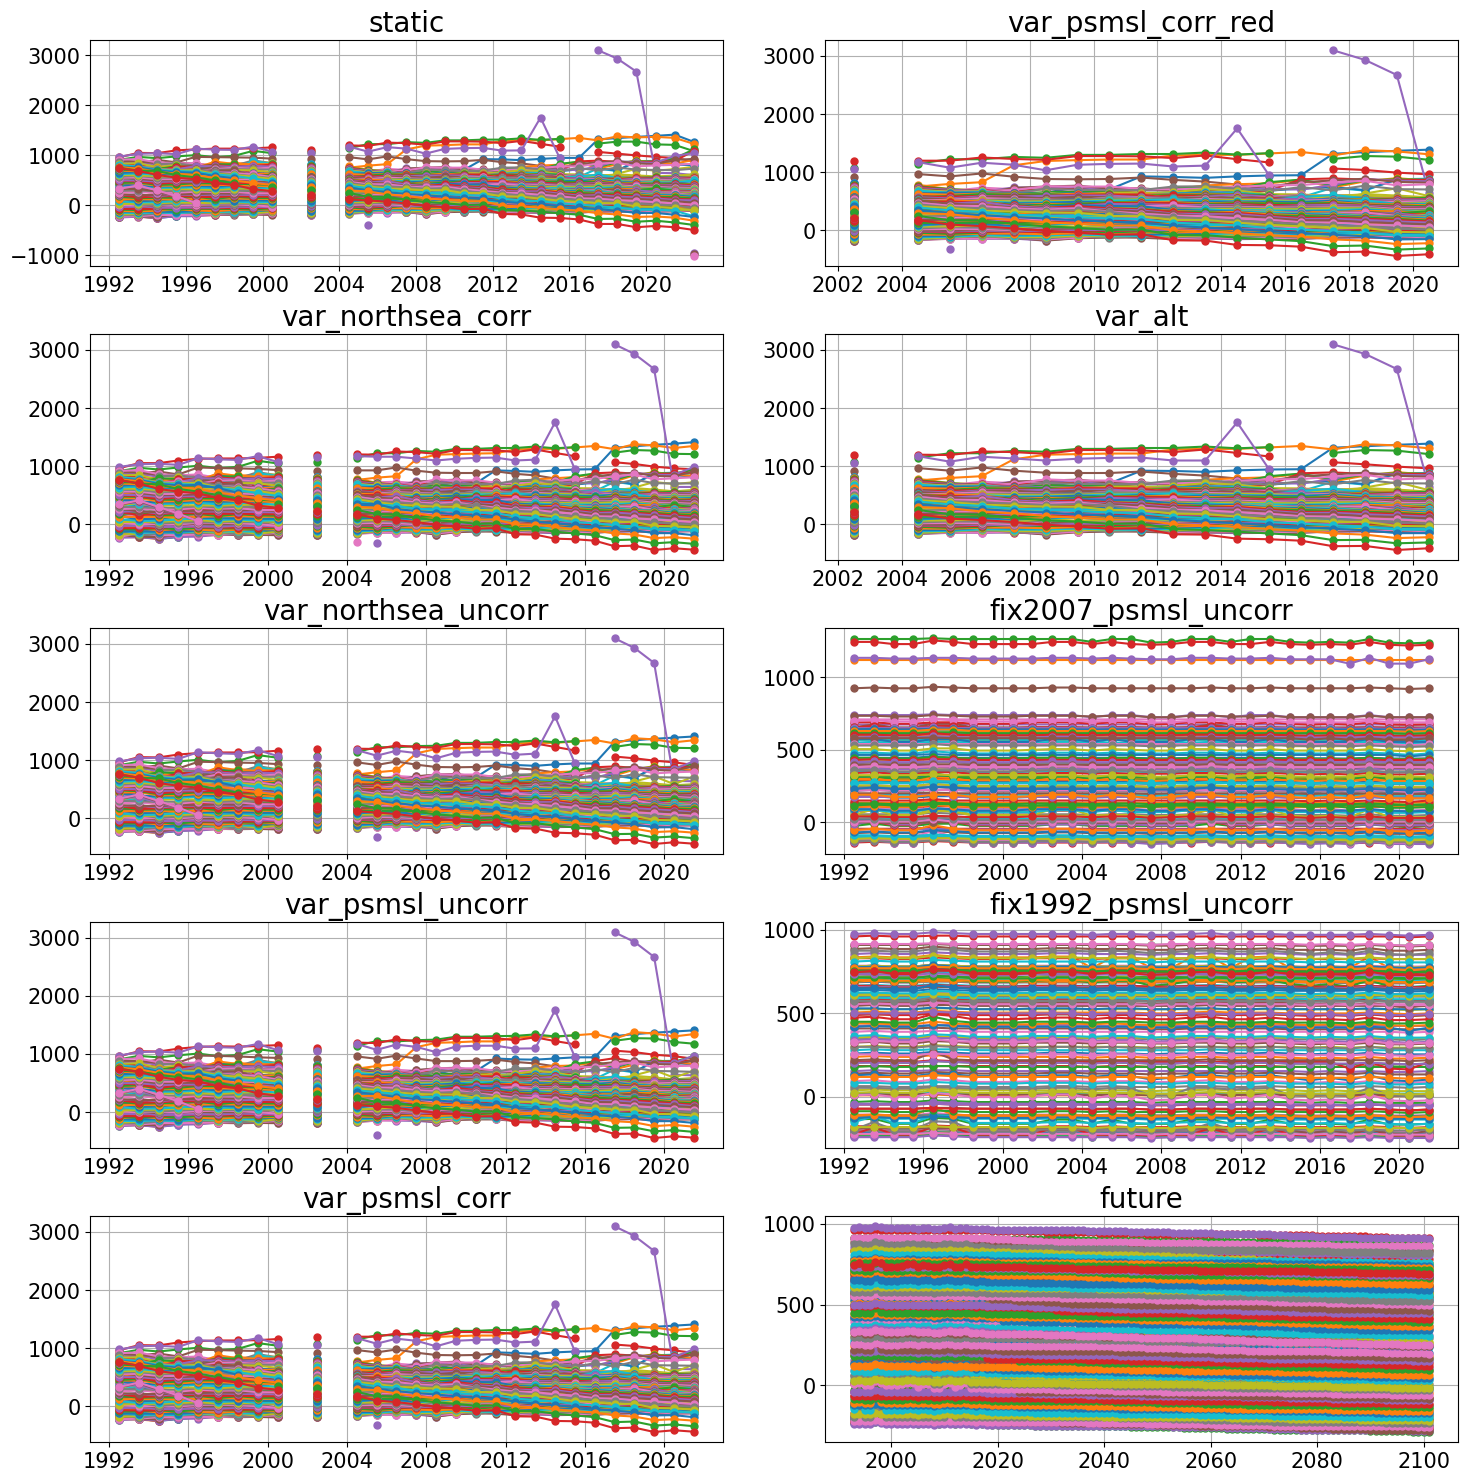

In [45]:
def plot_solution(timevec, ax, col):
    for transect in cd_jarkus.index:
        ts = cd_jarkus.loc[transect, col]
        if np.all(np.isnan(ts)):
            continue
        ax.plot(timevec, ts, '.-', markersize=10)
    ax.grid()
    ax.set_title(col)

fig, axs = plt.subplots(5,2, figsize=(15,15))
fig.tight_layout()
plot_solution(jarkus.time.values, axs[0,0], 'static')
plot_solution(jarkus.time.values, axs[1,0], 'var_northsea_corr')
plot_solution(jarkus.time.values, axs[2,0], 'var_northsea_uncorr')
plot_solution(jarkus.time.values, axs[3,0], 'var_psmsl_uncorr')
plot_solution(jarkus.time.values, axs[4,0], 'var_psmsl_corr')
plot_solution(jarkus.time.values, axs[0,1], 'var_psmsl_corr_red')
plot_solution(jarkus.time.values, axs[1,1], 'var_alt')
plot_solution(jarkus.time.values, axs[2,1], 'fix2007_psmsl_uncorr')
plot_solution(jarkus.time.values, axs[3,1], 'fix1992_psmsl_uncorr')
plot_solution(sl_pred.index, axs[4,1], 'future')       

### Cross-shore changes for three example transects

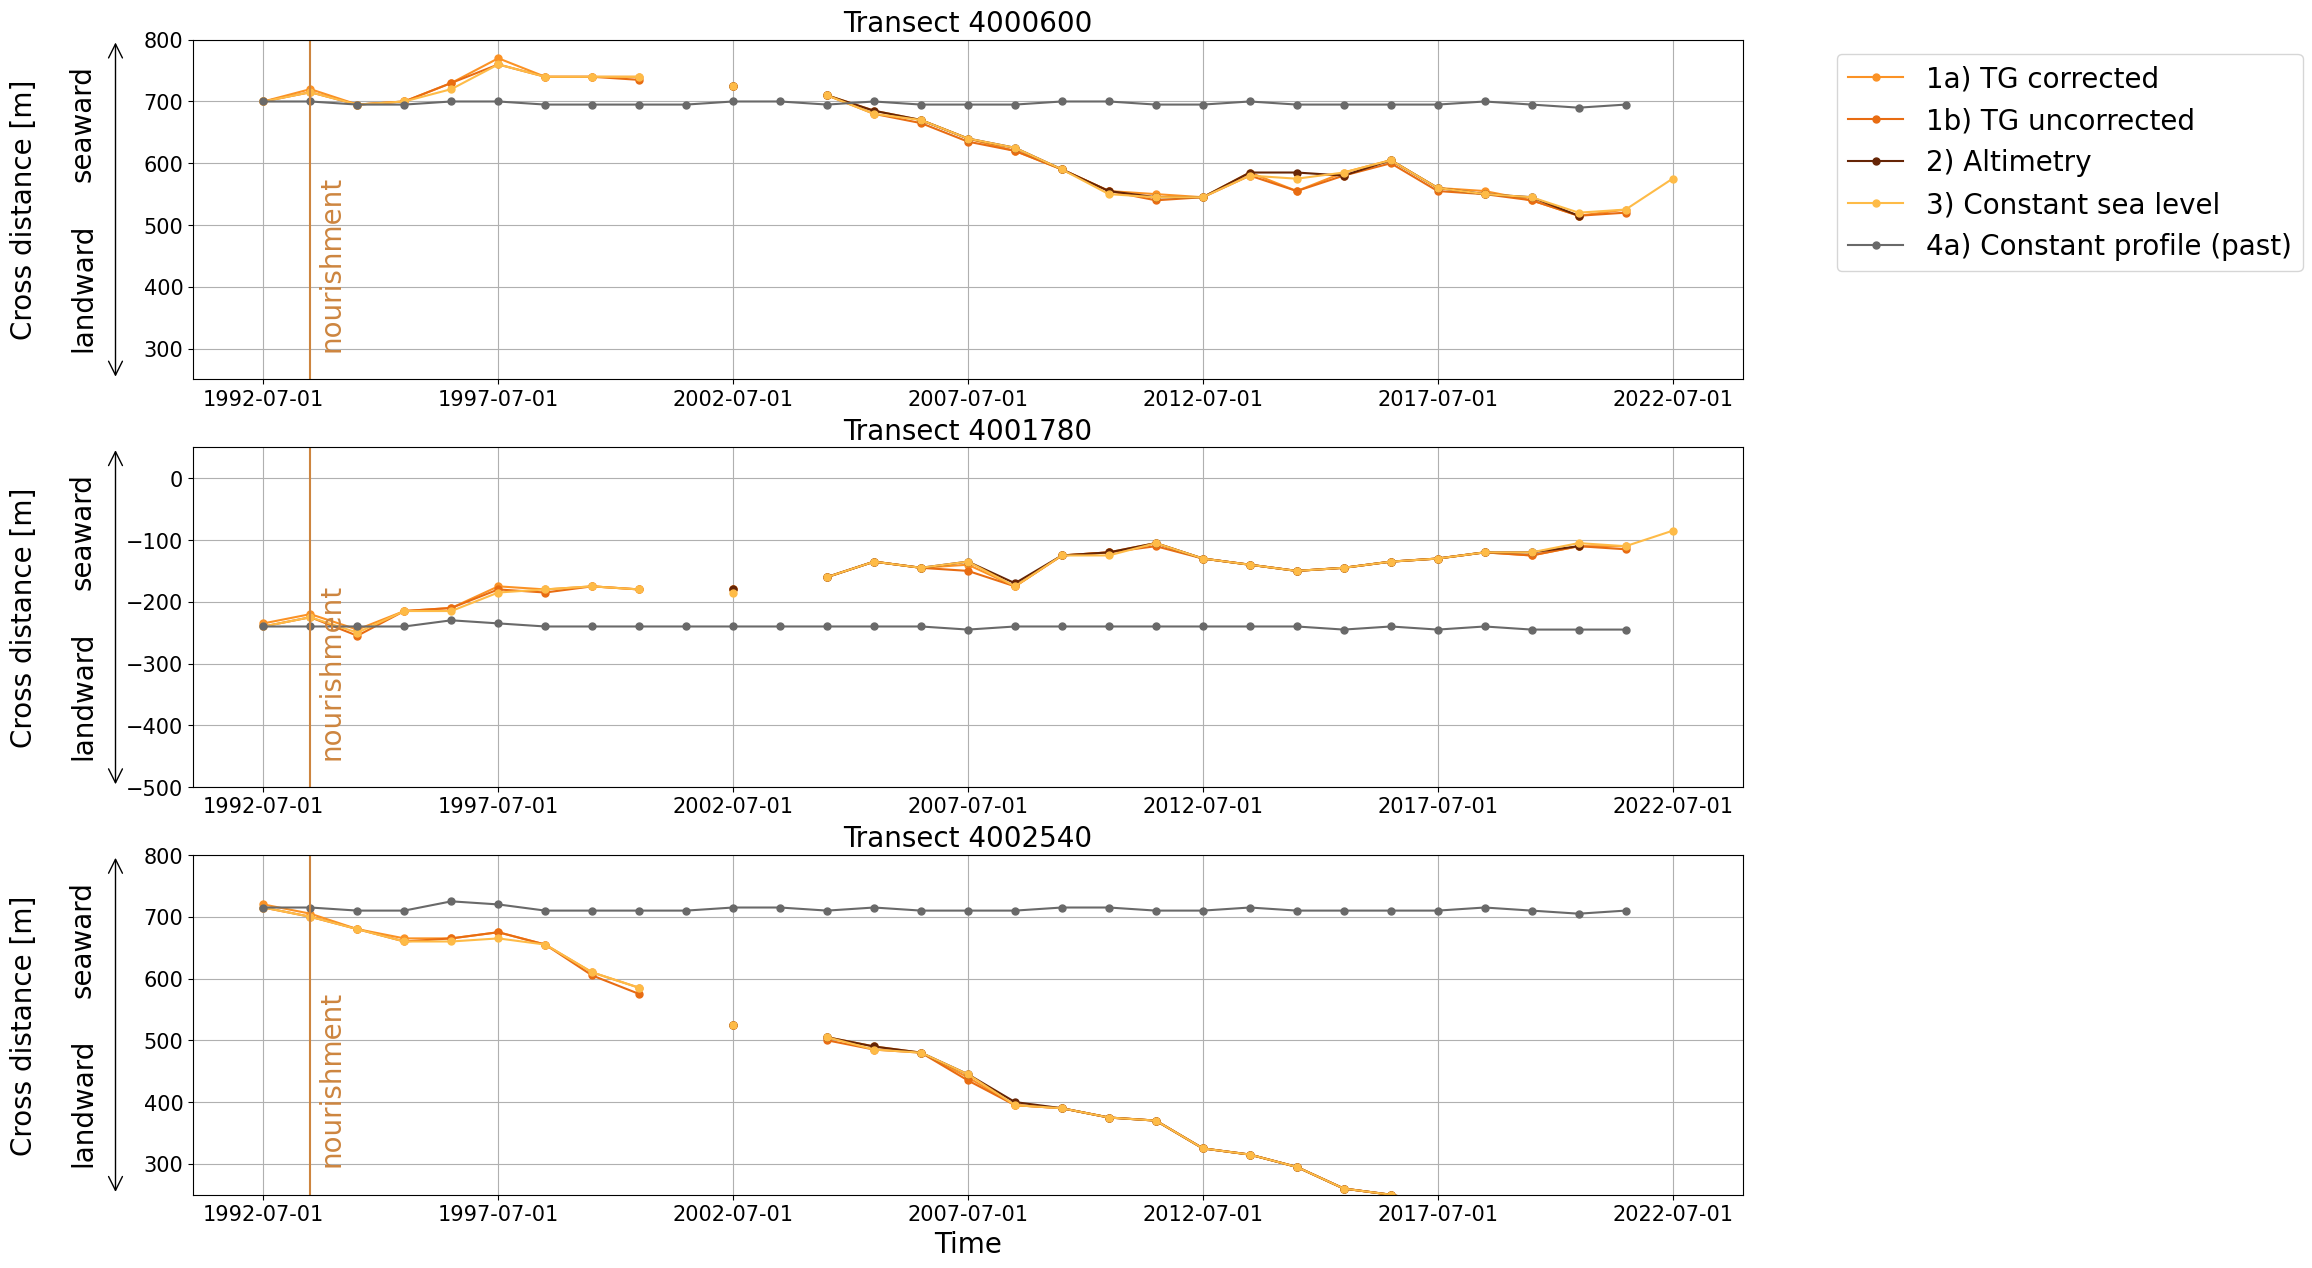

In [46]:
cmap = cm.get_cmap('YlOrBr')
color_list = cmap(np.linspace(0.4, 1, 6))

xticks = jarkus.time[0::5]
def plot_timeseries(ax, transect, vmin=None, vmax=None):
    ax.plot(jarkus.time, cd_jarkus.loc[transect, 'var_psmsl_corr'],'.-', markersize=10,
            color=color_list[1], label='1a) TG corrected')
    ax.plot(jarkus.time, cd_jarkus.loc[transect, 'var_psmsl_uncorr'],'.-', markersize=10,
            color=color_list[2], label='1b) TG uncorrected')
    ax.plot(jarkus.time, cd_jarkus.loc[transect, 'var_alt'],'.-', markersize=10,
            color=color_list[5], label='2) Altimetry')
    ax.plot(jarkus.time, cd_jarkus.loc[transect, 'static'],'.-', markersize=10,
            color=color_list[0], label='3) Constant sea level')
    ax.plot(jarkus.time, cd_jarkus.loc[transect, 'fix1992_psmsl_uncorr'],'.-', markersize=10,
            color='dimgrey', label='4a) Constant profile (past)')
    ax.grid()
    ax.set_title('Transect ' + str(transect))
    ax.set_xticks(xticks)
    ax.set_ylabel('Cross distance [m]')
    
    ax.yaxis.set_label_coords(-0.1,0.5)
    ax.set_ylim(vmin, vmax)
    
    ax.annotate('', xy=(-0.05, 0), xycoords='axes fraction', xytext=(-0.05, 1), 
            arrowprops=dict(arrowstyle="<->", mutation_scale=25));
    ax.text(-0.08, 0.1, 'landward', transform=ax.transAxes, fontsize=20, rotation='vertical')
    ax.text(-0.08, 0.6, 'seaward', transform=ax.transAxes, fontsize=20, rotation='vertical')
    
    ax.axvline(pd.to_datetime('1993-07-01'), c='peru')
    ax.text(0.08, 0.1, 'nourishment', transform=ax.transAxes, fontsize=20, rotation='vertical', c='peru')

fig, axs = plt.subplots(3,1, figsize=(20,15))
plot_timeseries(axs[0], 4000600, 250, 800)
plot_timeseries(axs[1], 4001780, -500, 50)
plot_timeseries(axs[2], 4002540, 250, 800)
axs[2].legend(bbox_to_anchor=(1.37,3.4))
axs[2].set_xlabel('Time');

plt.savefig('../99_plot_dump/jarkus_sl_3timeseries.png', dpi=dpi, bbox_inches='tight')

### Maps

In [47]:
# Coordinates of intersection transect/shoreline
if not (os.path.isfile(main_datapath_output + 'lat_mean.pkl') &
        (os.path.isfile(main_datapath_output + 'lon_mean.pkl'))):
    def get_lon_lat_mean():
        '''
        shoreline position averaged over time
        '''
        lat = []; lon = []
        for transect in cd_jarkus.index:
            idx_along = np.where(jarkus.id == transect)[0][0]

            for col in cd_jarkus.columns:
                ts = cd_jarkus.loc[transect, col]
                if np.all(np.isnan(ts)):
                    lat.append(np.nan)
                    lon.append(np.nan)
                    break
                cross_coord = np.nanmean(ts)
                diff_cross = jarkus.cross_shore - cross_coord
                closest_value = min(abs(diff_cross))
                idx_cross = np.where((diff_cross == -closest_value) | (diff_cross == closest_value))[0][0] 

                lat.append(jarkus.lat[idx_along, idx_cross].values)
                lon.append(jarkus.lon[idx_along, idx_cross].values)
                break
        return lon, lat

    lon_mean, lat_mean = get_lon_lat_mean()
    pickle.dump(lon_mean, open(main_datapath_output + 'lon_mean.pkl', 'wb'))
    pickle.dump(lat_mean, open(main_datapath_output + 'lat_mean.pkl', 'wb'))
else:
    lon_mean = pickle.load(open(main_datapath_output + 'lon_mean.pkl', 'rb'))
    lat_mean = pickle.load(open(main_datapath_output + 'lat_mean.pkl', 'rb'))

In [48]:
def plot_map(data, cmap, title='', label='', vmin=None, vmax=None):
    request = cimgt.GoogleTiles(style="satellite")
    # request = cimgt.OSM()

    fig, ax = plt.subplots(figsize=(25,10), subplot_kw=dict(projection=request.crs))
    ax.set_extent([5.1, 5.6, 53.32, 53.49], crs=ccrs.PlateCarree())
    ax.gridlines(draw_labels=True, zorder=0, color='lightgrey')
    ax.add_image(request, 11, alpha=0.7, zorder=0)

    # scale the dots according to the values
    # scale = (data - data.min())/(data.max() - data.min())
    # plot = ax.scatter(lon_mean, lat_mean, marker='o', s=100*np.abs(data), c=data, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    
    plot = ax.scatter(lon_mean, lat_mean, marker='o', s=100, c=data, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    
    plt.colorbar(plot, shrink=1, label=label)
    ax.set_title(title)
    return ax

#### Trends

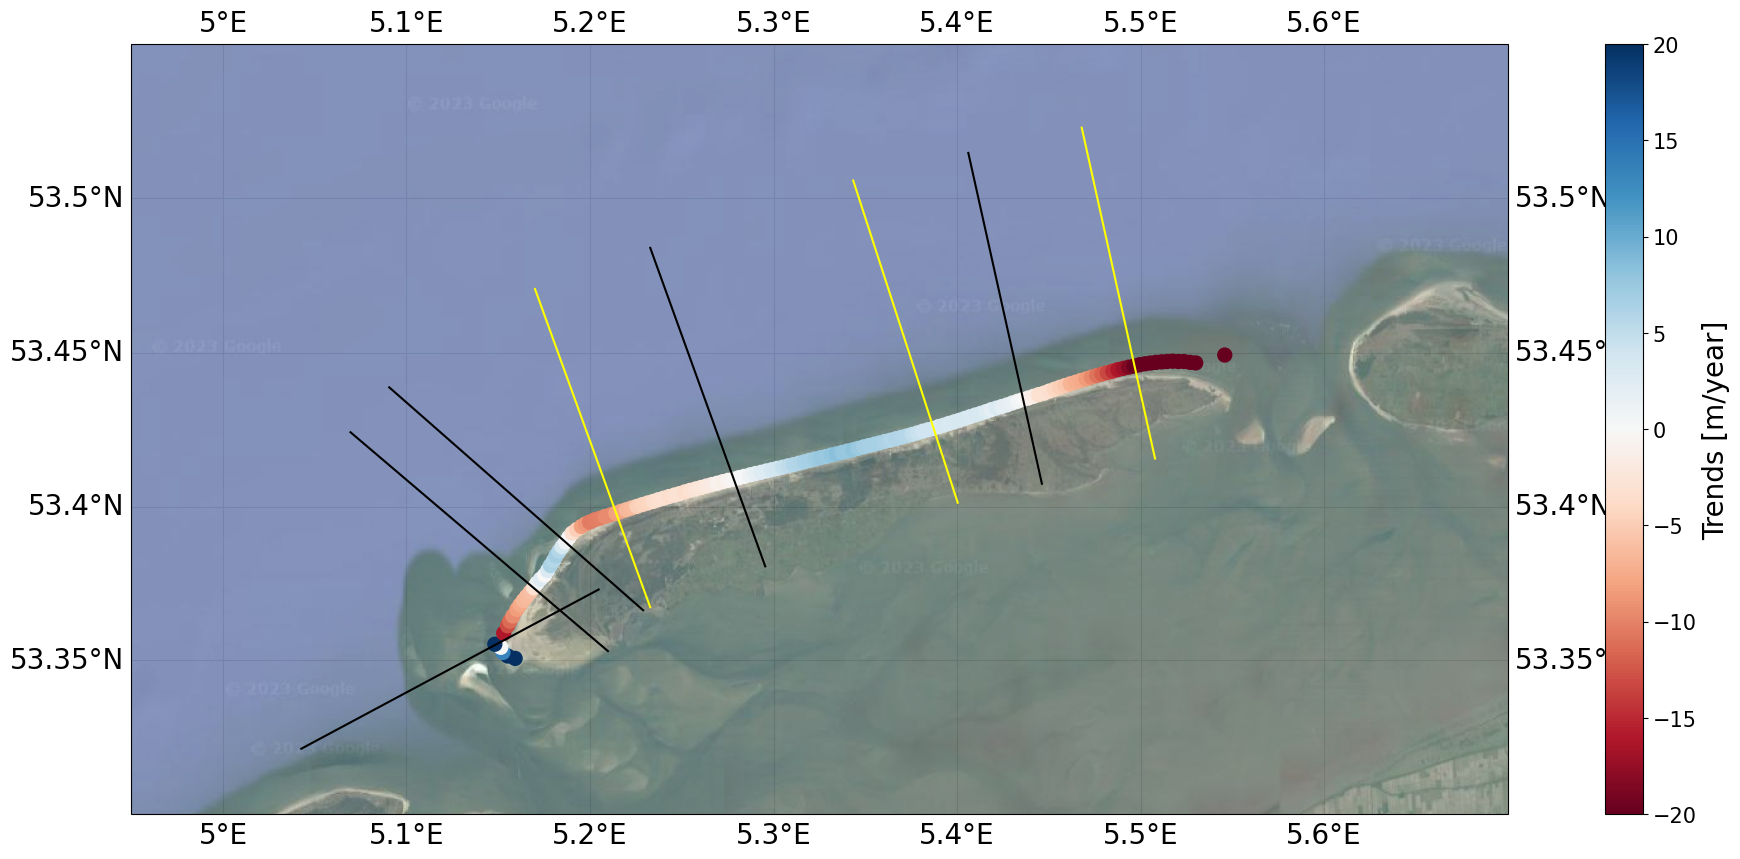

In [49]:
crs_32631 = ccrs.epsg('32631')
data = trend_jarkus['var_psmsl_uncorr']
ax = plot_map(data, 'RdBu', title='', label='Trends [m/year]', vmin=-20, vmax=20)

# transects with transition between erosive/accretive area
idx = np.where(np.abs(np.diff(np.sign(trend_jarkus['var_psmsl_uncorr'].dropna()))) == 2)
for transect in trend_jarkus.iloc[idx].index:
    ax.add_geometries(transects.loc[str(transect)].geometry, crs=crs_32631, edgecolor='k', linewidth=1.5)

# Example transects for the timeseries plot
example_transects = ['4000600', '4001780', '4002540']
for transect in example_transects:
    ax.add_geometries(transects.loc[str(transect)].geometry, crs=crs_32631, edgecolor='yellow', linewidth=1.5)

ax.set_extent([4.95, 5.7, 53.3, 53.55], crs=ccrs.PlateCarree())

plt.savefig('../99_plot_dump/map_jarkus_trend_psmsl_uncorr.png', dpi=dpi, bbox_inches='tight')

#### Beach slope

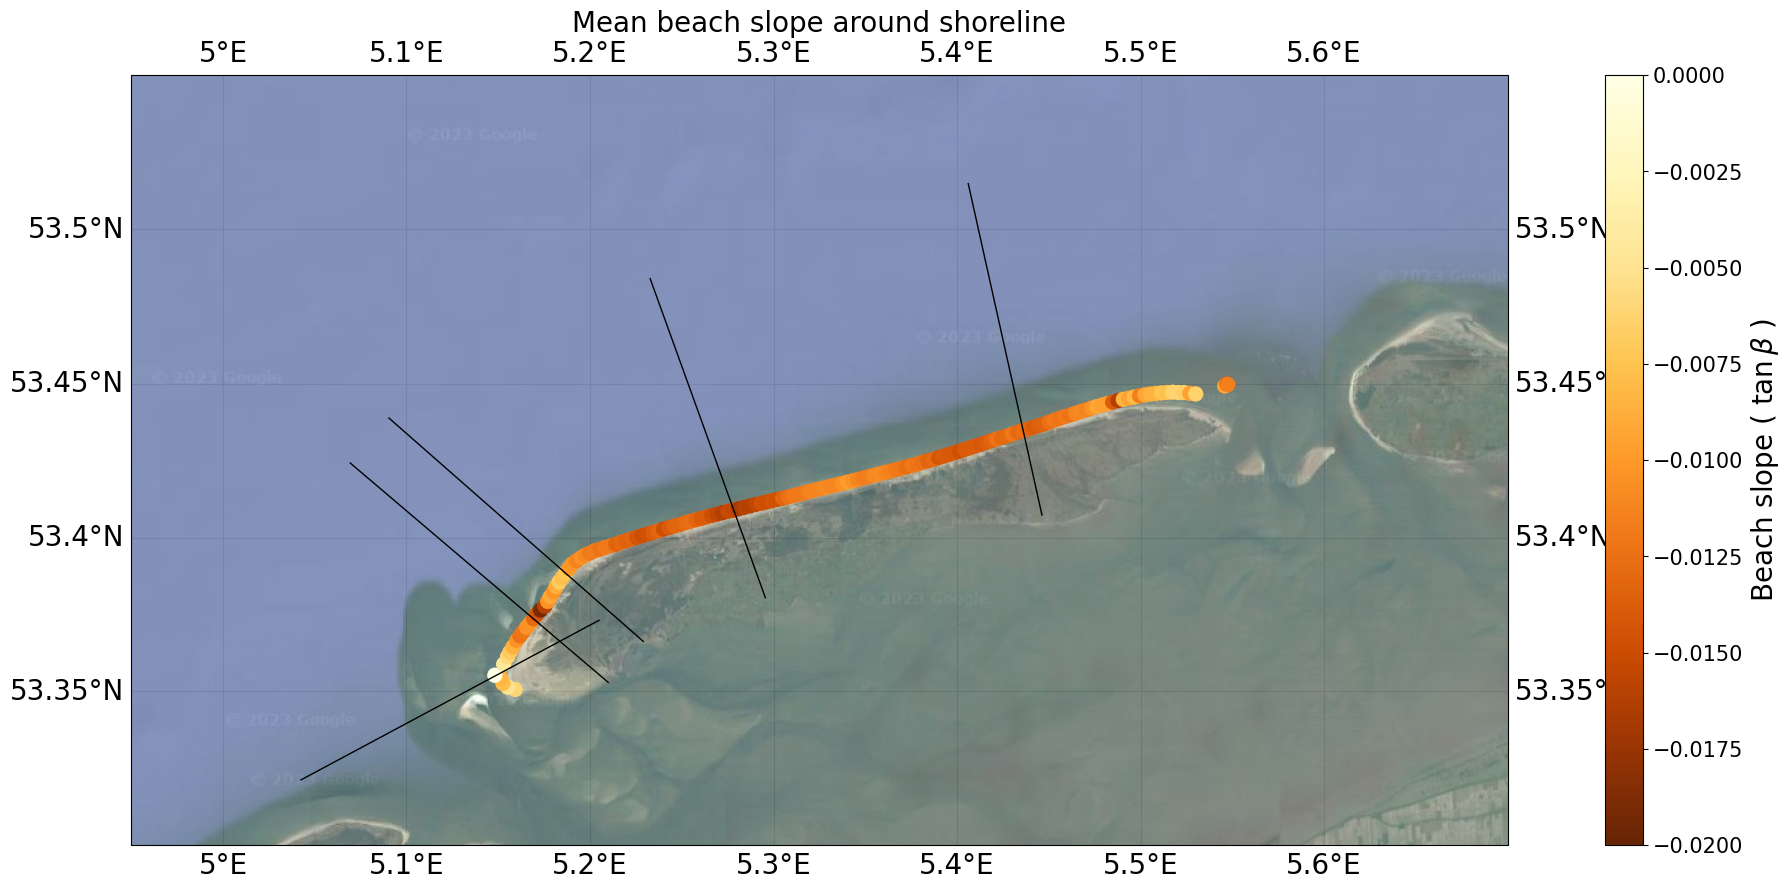

In [50]:
title = 'Mean beach slope around shoreline'
ax = plot_map(bs_mean, 'YlOrBr_r', title, r'Beach slope ( $\tan \beta$ )', vmin=-0.02, vmax=0)
# transects with transition between erosive/accretive area
idx = np.where(np.abs(np.diff(np.sign(trend_jarkus['var_psmsl_uncorr'].dropna()))) == 2)
for transect in trend_jarkus.iloc[idx].index:
    ax.add_geometries(transects.loc[str(transect)].geometry, crs=crs_32631, edgecolor='k')
ax.set_extent([4.95, 5.7, 53.3, 53.55], crs=ccrs.PlateCarree())

plt.savefig('../99_plot_dump/map_jarkus_beach_slope.png', dpi=dpi, bbox_inches='tight')

#### Trend vs beach slope

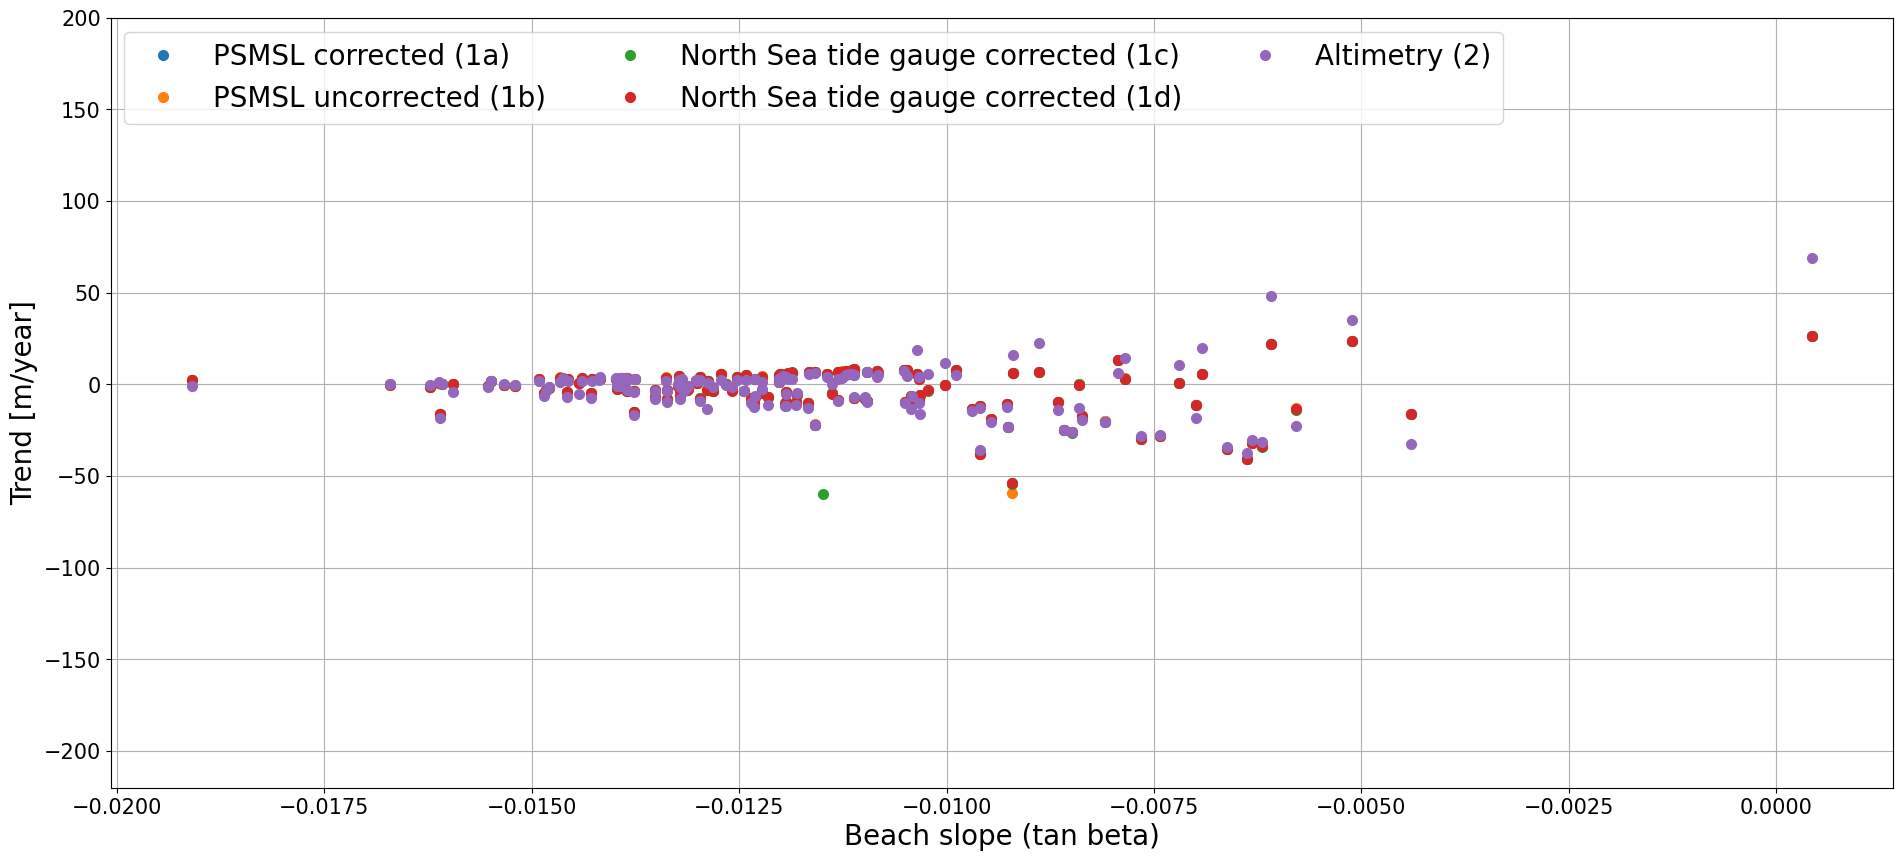

In [51]:
fig, ax = plt.subplots(figsize=(23,10))
ms = 7 # markersize
ax.plot(bs_mean, trend_jarkus['var_psmsl_corr'], 'o', markersize=ms, label='PSMSL corrected (1a)')
ax.plot(bs_mean, trend_jarkus['var_psmsl_uncorr'], 'o', markersize=ms, label='PSMSL uncorrected (1b)')
ax.plot(bs_mean, trend_jarkus['var_northsea_corr'], 'o', markersize=ms, label='North Sea tide gauge corrected (1c)')
ax.plot(bs_mean, trend_jarkus['var_northsea_uncorr'], 'o', markersize=ms, label='North Sea tide gauge corrected (1d)')
ax.plot(bs_mean, trend_jarkus['var_alt'], 'o', markersize=ms, label='Altimetry (2)')

# ax.plot(bs_mean, trend_jarkus['fix1992_psmsl_uncorr'], 'o', label='fix1992_psmsl_uncorr')
ax.set_xlabel('Beach slope (tan beta)')
ax.set_ylabel('Trend [m/year]')
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(-220, 200)
ax.grid()

# plt.savefig('../99_plot_dump/jarkus_trend_vs_beachslope.png', dpi=dpi, bbox_inches='tight')